# Using denamrf to estimate posteriors of GW150914

In [1]:
# Installing denamrf 
!pip install getdist denmarf

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Import libraries

import numpy as np
from scipy.stats import multivariate_normal
from denmarf import DensityEstimate

# Plotting
import matplotlib
from matplotlib import pyplot as plt
import getdist
from getdist import MCSamples, plots
%matplotlib inline
%config InlineBackend.figure_format="retina"

In [3]:
# #Import data from ligo
# !wget https://dcc.ligo.org/public/0157/P1800370/002/GWTC-1_sample_release.tar.gz
# !tar -xvzf GWTC-1_sample_release.tar.gz

In [4]:
%matplotlib inline

import h5py

import pandas as pd
from scipy.interpolate import interp1d
from astropy import cosmology, units

import bilby as bb
from bilby.core.prior import LogUniform, PriorDict, Uniform
from bilby.hyper.model import Model
import gwpopulation as gwpop

In [5]:
parameter_translator = dict(
    mass_1_det="m1_detector_frame_Msun",
    mass_2_det="m2_detector_frame_Msun",
    luminosity_distance="luminosity_distance_Mpc",
    a_1="spin1",
    a_2="spin2",
    cos_tilt_1="costilt1",
    cos_tilt_2="costilt2",
)

posteriors = list()
priors = list()

file_str = "./GWTC-1_sample_release/GW{}_GWTC-1.hdf5"

events = [
    "150914",
    "151012",
    "151226",
    "170104",
    "170608",
    "170729",
    "170809",
    "170814",
    "170818",
    "170823",
]
for event in events:
    _posterior = pd.DataFrame()
    _prior = pd.DataFrame()
    with h5py.File(file_str.format(event)) as ff:
        for my_key, gwtc_key in parameter_translator.items():
            _posterior[my_key] = ff["IMRPhenomPv2_posterior"][gwtc_key]
            _prior[my_key] = ff["prior"][gwtc_key]
    posteriors.append(_posterior)
    priors.append(_prior)

In [6]:
posteriors[0]

,mass_1_det,mass_2_det,luminosity_distance,a_1,a_2,cos_tilt_1,cos_tilt_2
0,43.561878,30.006974,360.963036,0.481479,0.551643,0.012162,0.137818
1,37.006684,35.723611,538.067256,0.323226,0.225597,0.454174,-0.482123
2,35.747480,34.267309,378.730720,0.490409,0.229346,-0.069300,-0.493216
3,45.168491,26.692544,446.937909,0.907815,0.128135,-0.127557,-0.694896
4,36.308165,35.889917,496.628291,0.144858,0.437158,0.487946,-0.237507
...,...,...,...,...,...,...,...
40831,38.577778,31.417375,503.472940,0.268453,0.194847,0.039890,-0.925528
40832,37.253314,33.156328,478.421089,0.805262,0.823590,0.655502,-0.985068
40833,40.528821,30.134671,516.916074,0.437801,0.408049,-0.277677,-0.280263
40834,35.683458,34.021918,464.564783,0.214438,0.819591,-0.557688,-0.119711


In [7]:
# Samples from the first three parameters
first_event = posteriors[0]

parameters = list()
training_index = int(len(first_event['mass_1_det'])*0.7)

for i in range(len(first_event['mass_1_det'])):
    parameters.append([first_event['mass_1_det'][i], first_event['mass_2_det'][i], first_event['luminosity_distance'][i]])

In [8]:
# Denmarf density estimation
de = DensityEstimate().fit(
    parameters,
    num_blocks=2,
    num_hidden=5,
    num_epochs=100,
)

current average log likelihood: -10.385: 100%|██████████| 100/100 [02:11<00:00,  1.31s/it]

best average log likelihood: -10.320


In [9]:
# True data for evaluation, using the remaining 30% of data
parameters_eval = list()

for i in range(training_index, len(first_event['mass_1_det'])):
    parameters_eval.append([first_event['mass_1_det'][i], first_event['mass_2_det'][i], first_event['luminosity_distance'][i]])
    
parameters_eval = np.array(parameters_eval)

Removed no burn in
Removed no burn in


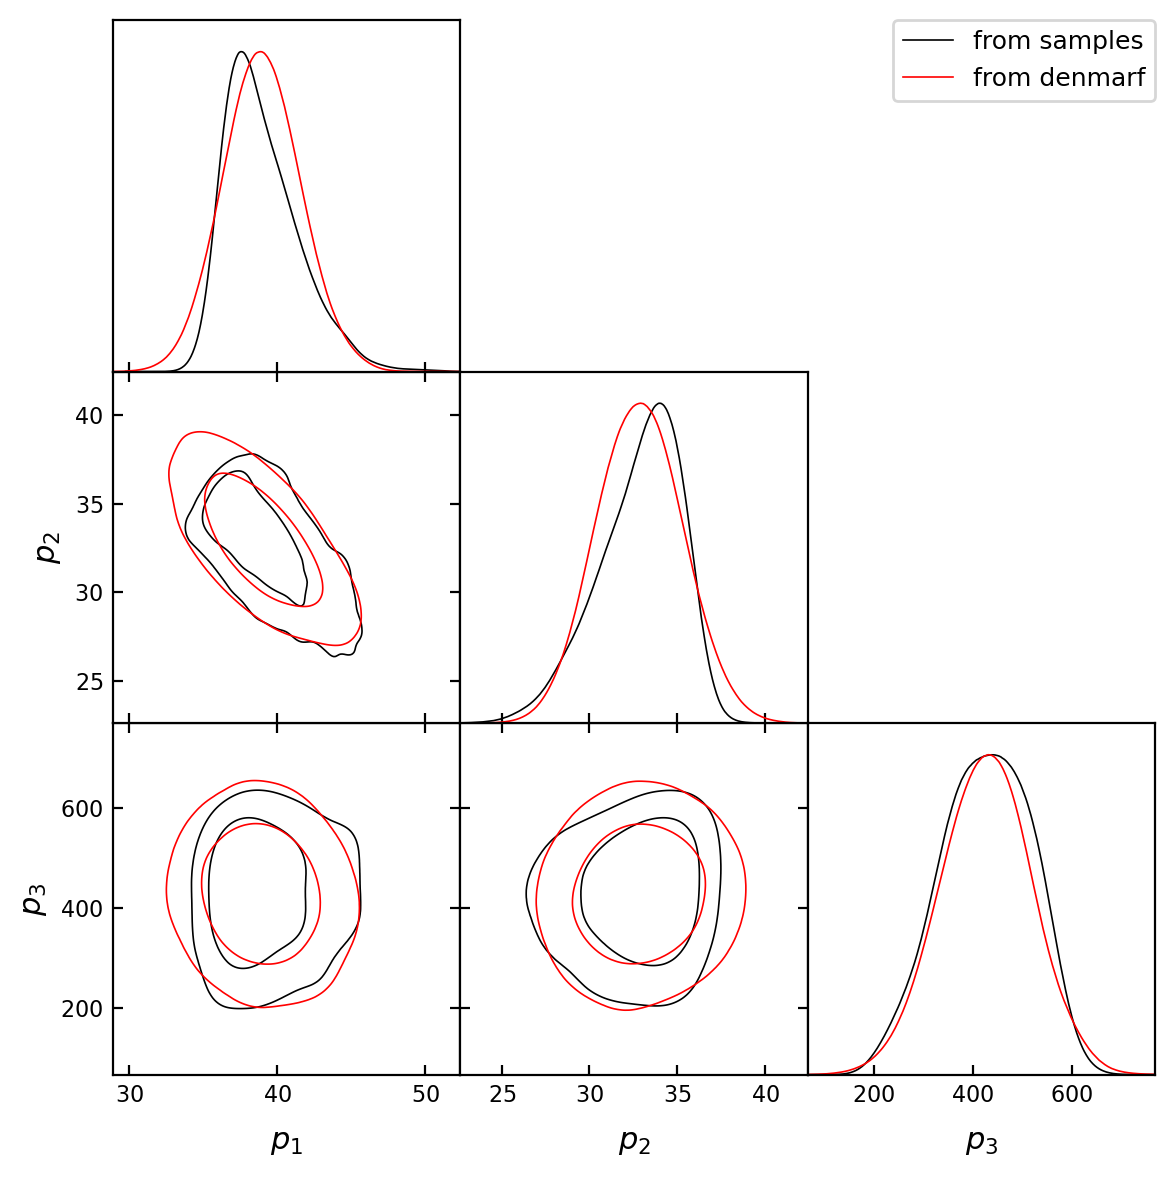

In [10]:
samples_exact = MCSamples(samples=parameters_eval, label="from samples")

xgen_maf = de.sample(12000)
samples_maf = MCSamples(samples=xgen_maf, label="from denmarf")
g1 = plots.get_subplot_plotter()
g1.triangle_plot([samples_exact, samples_maf], filled=False)

## Tuning parameters of the model to achieve better results

### Doubling the num_blocks

current average log likelihood: -10.370: 100%|██████████| 100/100 [03:03<00:00,  1.83s/it]


best average log likelihood: -10.273
Removed no burn in
Removed no burn in


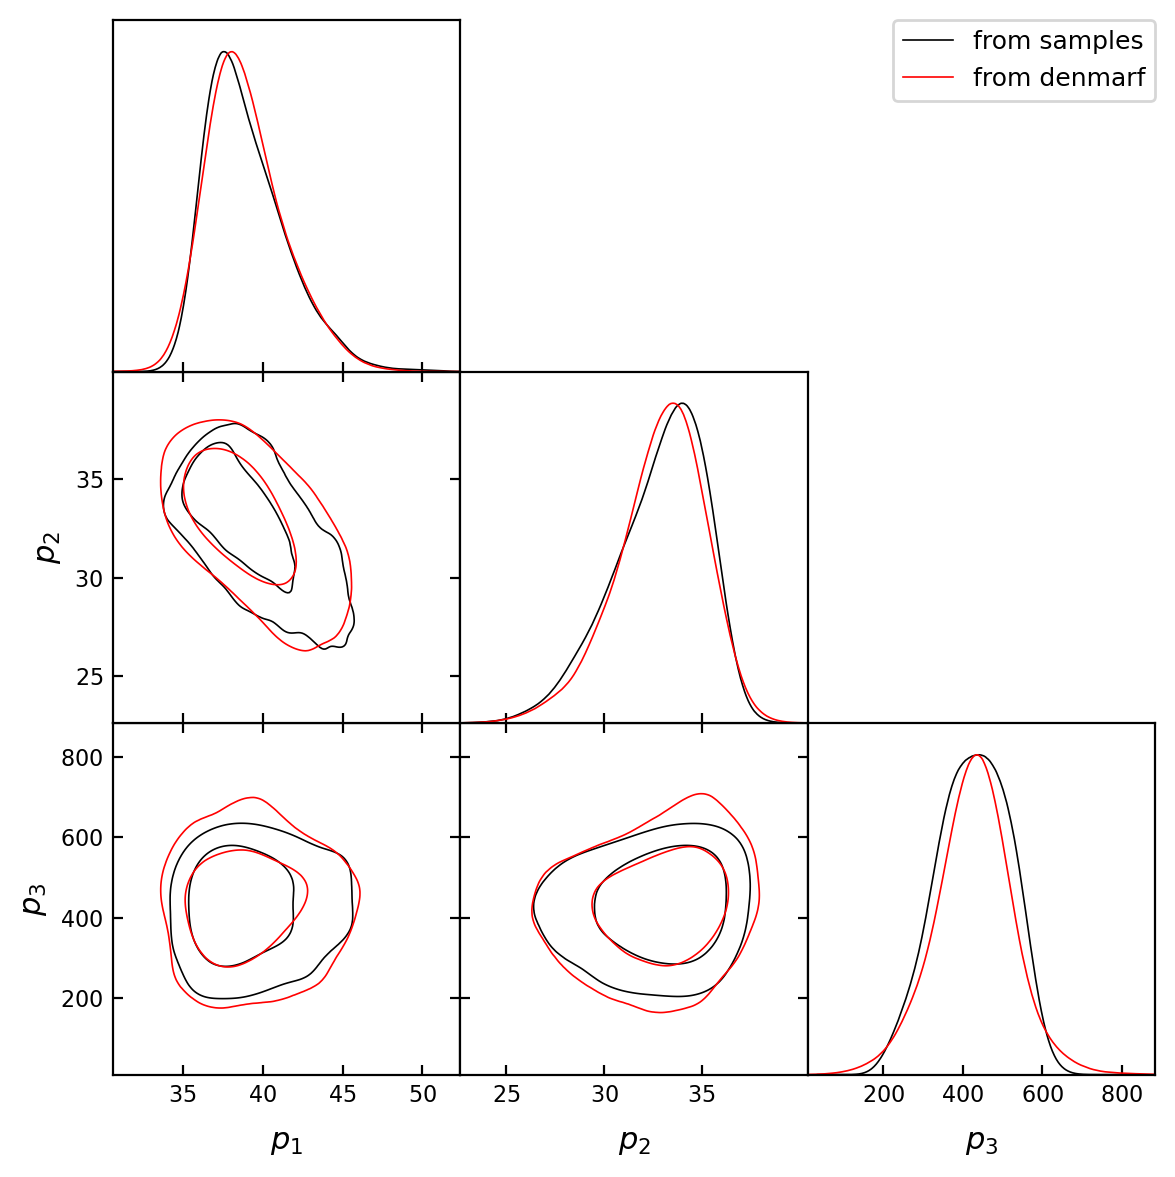

In [11]:
de1 = DensityEstimate().fit(
    parameters,
    num_blocks=4,
    num_hidden=5,
    num_epochs=100,
)

samples_exact = MCSamples(samples=parameters_eval, label="from samples")

xgen_maf = de1.sample(12000)
samples_maf = MCSamples(samples=xgen_maf, label="from denmarf")
g1 = plots.get_subplot_plotter()
g1.triangle_plot([samples_exact, samples_maf], filled=False)

### Doubling the num_hidden

current average log likelihood: -10.357: 100%|██████████| 100/100 [03:29<00:00,  2.09s/it]

best average log likelihood: -10.319
Removed no burn in


Removed no burn in


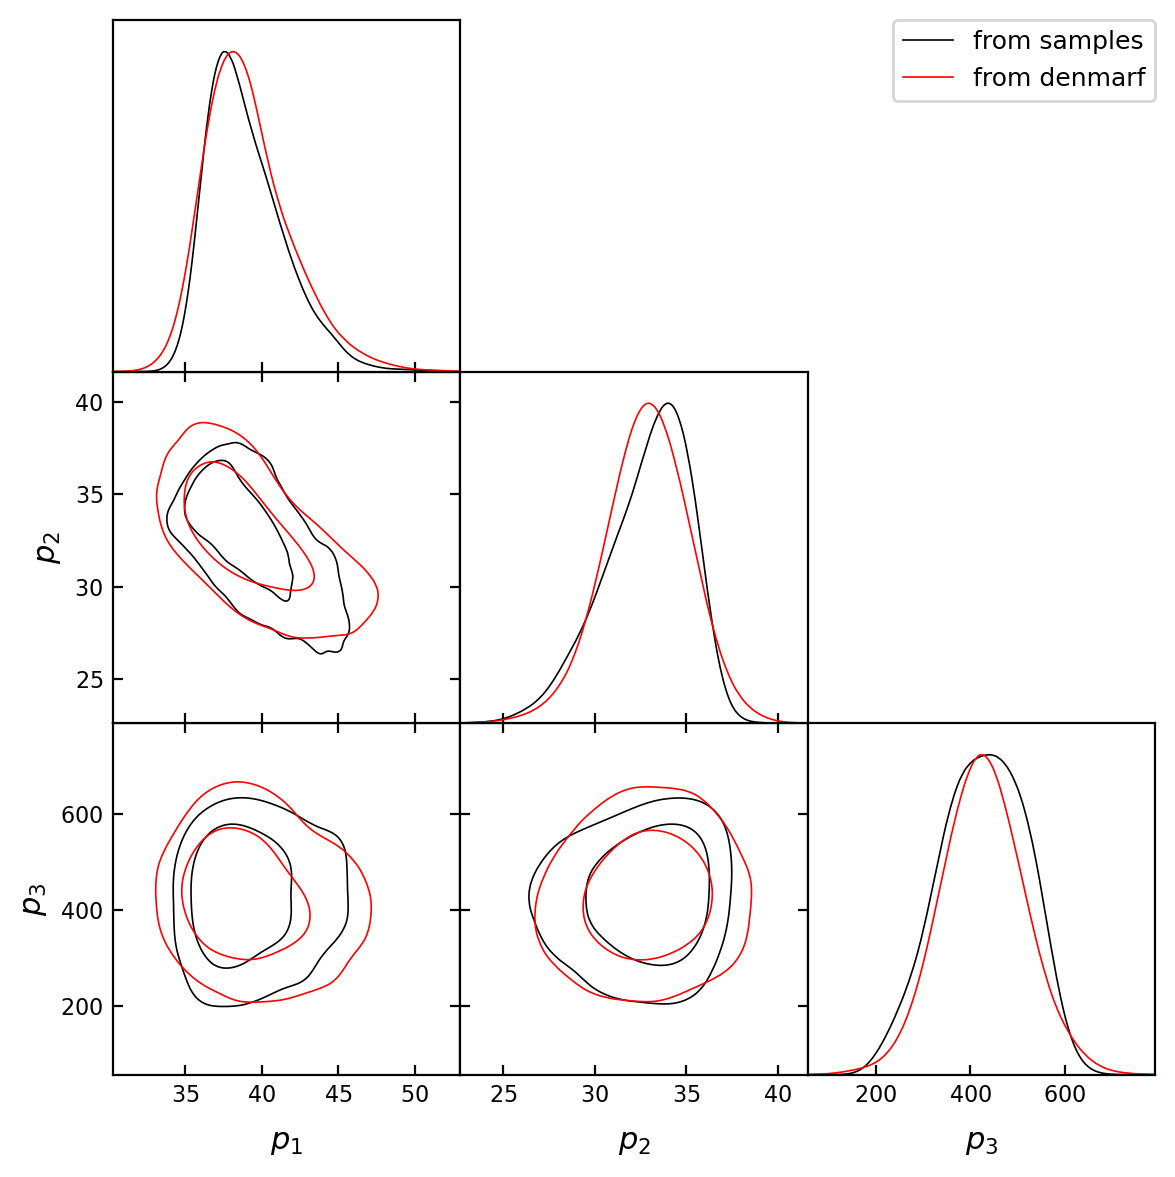

In [12]:
de2 = DensityEstimate().fit(
    parameters,
    num_blocks=2,
    num_hidden=10,
    num_epochs=100,
)

samples_exact = MCSamples(samples=parameters_eval, label="from samples")

xgen_maf = de2.sample(12000)
samples_maf = MCSamples(samples=xgen_maf, label="from denmarf")
g1 = plots.get_subplot_plotter()
g1.triangle_plot([samples_exact, samples_maf], filled=False)

### Doubling the num_epochs

current average log likelihood: -10.293: 100%|██████████| 200/200 [04:19<00:00,  1.30s/it]


best average log likelihood: -10.271
Removed no burn in
Removed no burn in


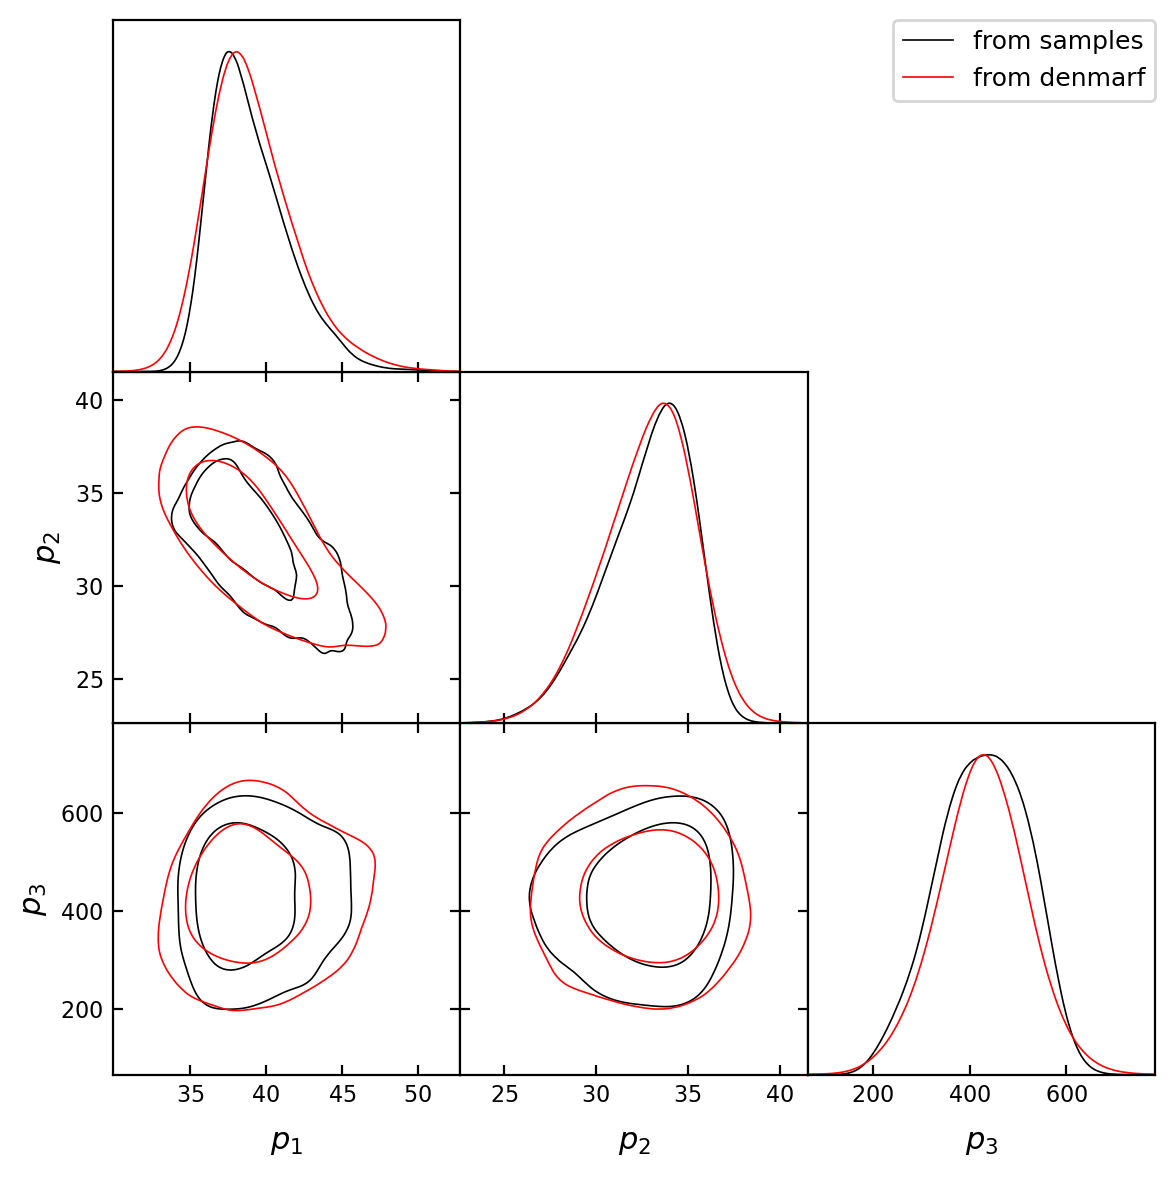

In [13]:
de3 = DensityEstimate().fit(
    parameters,
    num_blocks=2,
    num_hidden=5,
    num_epochs=200,
)

samples_exact = MCSamples(samples=parameters_eval, label="from samples")

xgen_maf = de3.sample(12000)
samples_maf = MCSamples(samples=xgen_maf, label="from denmarf")
g1 = plots.get_subplot_plotter()
g1.triangle_plot([samples_exact, samples_maf], filled=False)

## Using KDE to estimate
    It seems to take forever long, given up using it

In [14]:
# from scipy import stats
# import time

# m1, m2, dL = first_event['mass_1_det'], first_event['mass_2_det'], first_event['luminosity_distance']

In [15]:
# X, Y, Z = np.mgrid[m1.min():m1.max():1000j, m2.min():m2.max():1000j, dL.min():dL.max():1000j]

# positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])

# values = np.vstack([m1, m2, dL])

# start_time = time.time()
# kernel = stats.gaussian_kde(values)
# end_time = time.time()

# hyperX = np.reshape(kernel(positions).T, X.shape)

# print('Time taken for KDE: {}'.format(end_time-start_time))